In [16]:
# import all relevant libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib

import wfdb

from fastai.tabular.all import *
from tsai.all import *

# assign the correct path to downloaded data and filenames
# realpath is this script path, while data is subfolder in the same dir
# parent_dir =  os.path.dirname(os.path.realpath(__file__))

parent_dir = pathlib.Path(os.path.abspath('')).parents[0]
data_dir = os.path.join(parent_dir, 'data\\')
raw_dir = os.path.join(parent_dir, 'data\\raw\\')
processed_dir = os.path.join(parent_dir, 'data\\processed\\')


filenames = []

for i in range(10):
    filenames.append('infant'+str(i+1))

# print and list all relevant filenames, as a quick check
print(parent_dir)
print(data_dir)
print(processed_dir)
print(filenames)


def describe_df(df):
    desc = df.describe()
    desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
    desc.loc['nunique'] = df.nunique()
    desc.loc['count_na'] = df.isna().sum()
    desc.iloc[1:] = desc.iloc[1:].applymap('{:.6f}'.format)
    print(desc)


f:\Education\ecg_resp
f:\Education\ecg_resp\data\
f:\Education\ecg_resp\data\processed\
['infant1', 'infant2', 'infant3', 'infant4', 'infant5', 'infant6', 'infant7', 'infant8', 'infant9', 'infant10']


In [17]:
# import preprocessing folders & shared functions
import sys
sys.path.append(os.path.join(parent_dir, 'preprocessing/'))

import self_shared as ss


In [23]:
df = ss.read_df(filenames, processed_dir, i = 0, j = 1)
dfr = ss.gen_dfr(df)

dfm = pd.merge(df, dfr, on=['id'], how='left')
dfm = dfm.drop_duplicates()
dfm = dfm.dropna()


df.shape, dfr.shape, dfm.shape


index 0 is out of bounds for axis 0 with size 0
min() arg is an empty sequence
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
min() arg is an empty sequence


((480881, 7), (957, 3), (453708, 9))

In [43]:
# group data into unique continuous hrs, i.e. the generated id
dfg = df.groupby('id')['resp'].apply(list).reset_index(name='resp')

# add back corresponding hrs to each id
dfg = pd.merge(dfg, dfr[['id', 'hr']], on='id', how='left')

# pad data to match maxed length
max_length = 501
dfg['resp'] = dfg['resp'].apply(lambda x: np.pad(x, (0, max_length-len(x)), 'mean'))

# display data
dfg = dfg.dropna()

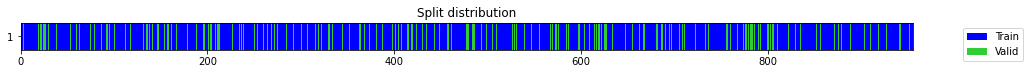

X      - shape: [956 samples x 1 features x 501 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (956,)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [765, 191]  overlap: False


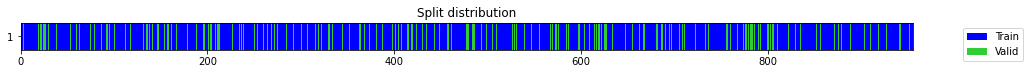

In [59]:
# reformatting data
X = np.array(dfg['resp'].tolist())

y = dfg['hr'].to_numpy()


X = to3d(X)
X.shape, y.shape

splits = get_splits(y, valid_size=.2, stratify=True,
                    random_state=23, shuffle=True)

check_data(X, y, splits)


In [61]:


tfms = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms,
                 batch_tfms=batch_tfms, bs=128)
dls.one_batch()


(TSTensor(samples:128, vars:1, len:501, device=cpu, dtype=torch.float32),
 tensor([148.7603, 148.7603, 153.6885, 144.9580, 150.0000, 156.2500, 157.5758,
         154.5064, 150.9434, 161.1570, 141.9355, 162.0000, 127.9318, 146.8085,
         155.6017, 151.2605, 162.5000, 150.0000, 139.2405, 100.6711, 147.8439,
         151.5789, 143.4511, 107.5949, 154.9296, 150.3132, 150.3132, 138.0753,
         156.9038, 150.0000, 157.8947, 123.7113, 149.0683, 150.9434, 150.3132,
         144.0501, 145.7490, 148.1481, 150.9434, 149.0683, 149.3776, 155.6017,
         168.3992, 154.3210, 173.9130, 139.9594, 167.7019, 142.2414, 147.1215,
         160.3774, 151.8987, 135.1931, 148.1481,  63.8298, 142.5620, 149.3776,
         139.8305, 150.0000, 141.3276, 160.1643, 158.8595,  80.4124, 159.5092,
         165.3061, 164.9049, 151.2097, 152.2199, 134.9693, 161.9718, 150.0000,
         160.4938, 144.3515, 148.7603, 159.2357, 152.7495, 153.1915, 150.0000,
         149.0683, 144.9580, 154.6392, 152.5424, 146.1864

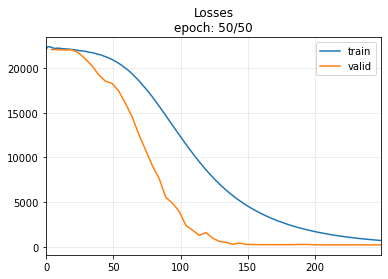

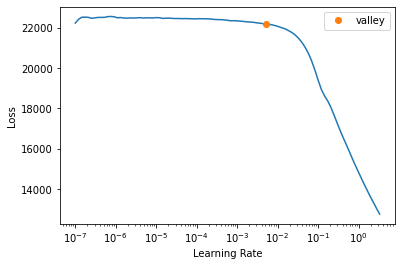

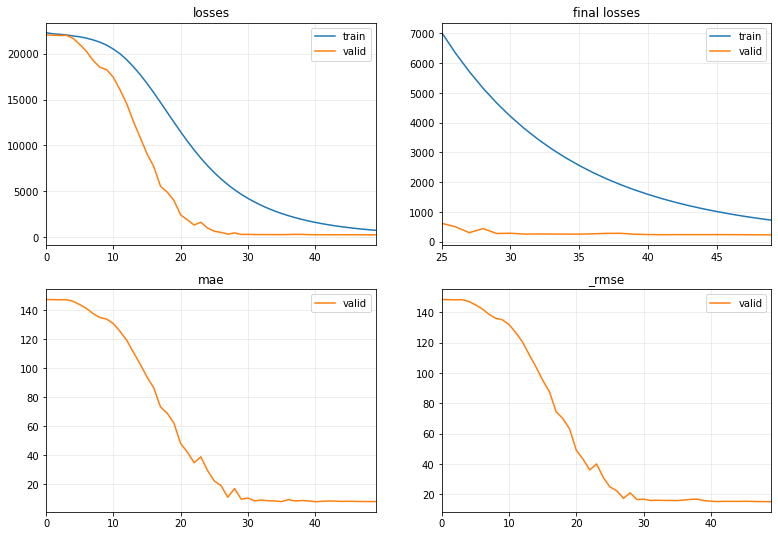

In [63]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn_rate = learn.lr_find()
learn.fit_one_cycle(50, learn_rate)


In [68]:
# save the model

PATH = Path('../models/Regression.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

# delete the variable
del learn

# load back the model
PATH = Path('../models/Regression.pkl')
model = load_learner(PATH, cpu=False)


In [71]:
# quick check of mse vs last learn mse
from sklearn import metrics as skm

probas, _, preds = model.get_X_preds(X[splits[0]])
result_mse = skm.mean_squared_error(y[splits[0]], preds, squared=False)
result_r2 = skm.r2_score(y[splits[0]], preds)

result_mse, result_r2


(11.969204114135037, 0.1739558477754739)

In [67]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score


data = dfm
dl = learn.dls.test_dl(data)

pred, test_y = learn.get_preds(dl=dl)

# RMSE Computation
r_mse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" % (r_mse))

# r2square compution
r2 = r2_score(test_y, pred)
print("R2 : % f" % (r2))


y_actual = test_y.numpy().flatten()
y_pred = pred.numpy().flatten()

dft = pd.DataFrame({'y_actual': y_actual, 'y_pred': y_pred})

# dft = dft[dft['y_pred'] > 0]

sns.regplot(data=dft, x='y_actual', y='y_pred')


TypeError: 'NoneType' object is not iterable